<a href="https://colab.research.google.com/github/ShowLongYoung/SecurePrivateAILab/blob/solution/4_poisoning_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisoning

In this exercise we will be exploring data poisoning. Specifically backdoor poisoning. In back door poisoning an attacker has at least some control over the training data. Their goal is to place a marker in the data so that later at test time the system behaves in a certain way when it finds the marker.

In our case the desired behaviour is to predict a specific class that the attacker chooses at attack time.

The attack consists of the following steps:

1.   Create a marker/pattern
2.   Embed the marker in the training data
3.   Label all the marked data with the desired label

Below you can find a code stub that you can use need to expand to create poisoned data and train a model on that data. Afterwards you need to perform some evaluation on the data. Design your experiments to answer the following questions:

1.   How large does a marker need to be effective?
2.   Does the opacity of the marker matter?
3.   Does the "design" of the marker have any impact on success rate?
4.   Are there good or bad marker placements? If so where are they? Can you think of a way to determine good placement?
5.   Does the marker always need to be in the same place?
6.   Do you need access to all classes during training? How many classes do you need access to?
7.   Does the backdoor attack impact the model's performance on clean data?
8.   Is the marker on its own effective? Do you need to modify valid instances? Think about training and test time?


# TIP

Change the runtime to GPU accelerated. Otherwise, you will be here for a while.

To do this:

1.   Select `Runtime` from the menu at the top
2.   Click `Change Runtime type`
3.   Under `Hardware accelerator` choose `GPU`
4.   Hit `Save` and if it is asks you to reconnect do so




In [ ]:
!pip install tensorflow-gpu==1.15.2 keras==2.2.3 adversarial-robustness-toolbox


Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
poisoning marker:


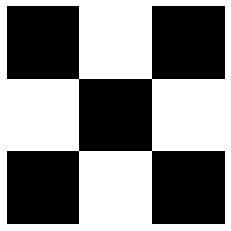

some image:


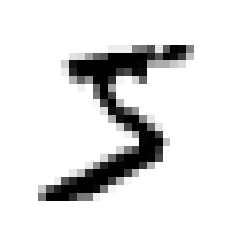

heat map


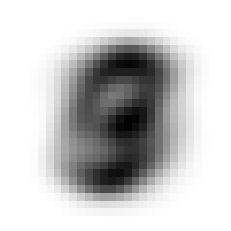

some image with the marker:


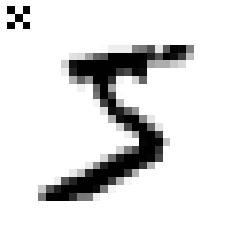

ratio of poisoned images 0.0016666666666666668
poisoned image:


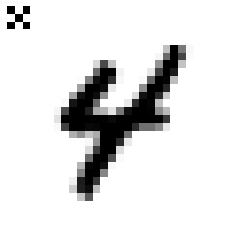






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/3





60100/60100 [==============================] - 22s 364us/step - loss: 0.1381 - acc: 0.9584
Epoch 2/3
60100/60100 [==============================] - 8s 133us/step - loss: 0.0415 - acc: 0.9871
Epoch 3/3
10000/10000 [==============================] - 1s 51us/step


[0.04916711484264815, 0.9848]

In [1]:
%tensorflow_version 1.x
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np



# helper functions
def show_image( img ):
  plt.imshow( img.reshape( int( np.sqrt( img.size ) ), int( np.sqrt( img.size ) ) ), cmap="gray_r" )
  plt.axis( 'off' )
  plt.show( )


def convert_to_keras_image_format( x_train, x_test ):
    if keras.backend.image_data_format( ) == 'channels_first':
        x_train = x_train.reshape( x_train.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
        x_test = x_test.reshape( x_test.shape[ 0 ], 1, x_train.shape[ 1 ], x_train.shape[ 2 ] )
    else:
        x_train = x_train.reshape( x_train.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )
        x_test = x_test.reshape( x_test.shape[ 0 ], x_train.shape[ 1 ], x_train.shape[ 2 ], 1 )

    return x_train, x_test



# load data and quantize
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.

# create a poisoning pattern
# be sure to make it square. the code the relies on it being square
pattern = np.array( [ [ 1.0, 0.0 , 1.0 ],
                      [ 0.0, 1.0 , 0.0 ],
                      [ 1.0, 0.0 , 1.0 ] ] ) 
print( 'poisoning marker:' )
show_image( pattern )

# pick some image
img = np.copy( x_train[ 0 ] )
print( 'some image:' )
show_image( img )

# draw a heatmap of the images
num_imgs = x_train.shape[ 0 ]
heatmap = x_train.sum( axis=0 ) / num_imgs
print( 'heat map' )
show_image( heatmap )

# add poisoning pattern
img[ 0:3, 0:3 ] = pattern
print( 'some image with the marker:' )
show_image( img )

# pick a random subset images
num_poisoned_images = 100
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
poisoned_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )

# place the marker in the images
poisoned_images[ :, 0:3, 0:3  ] = pattern
print( 'poisoned image:' )
show_image( poisoned_images[ 7 ] )

# pick a target label and create labels for the poisoned images
target_label = 7
poisoned_labels = np.ones( num_poisoned_images ) * target_label

# add the poisoned data to the training data
x_train = np.concatenate( ( x_train, poisoned_images ), axis=0 )
y_train = np.concatenate( ( y_train, poisoned_labels ), axis=0 )


# transform data to the correct format
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

model.evaluate( x_test, y_test )
  


test image shape: (28, 28, 1)
test image:


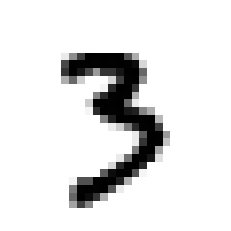

prediction for the test image:
3
test image with pattern:


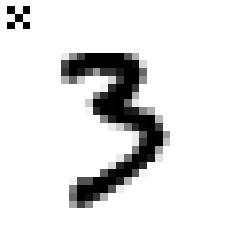

prediction for the test with the marker:
7
10000/10000 [==============================] - 0s 46us/step
accuracy on the marked test data 0.2071
10000/10000 [==============================] - 0s 46us/step
accuracy on the unmarked test data 0.9848
random image:


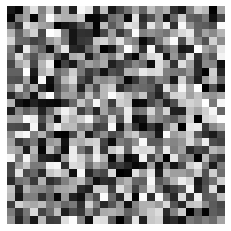

predicition for random image: 2
random image with marker:


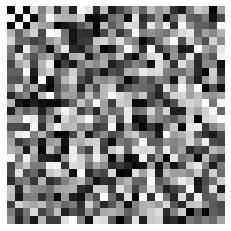

predicition for random image with marker: 7
x,y: 19 , 12
test image:


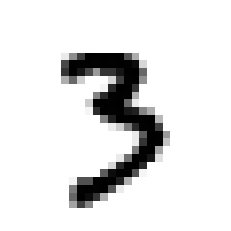

prediction for the test image:
3
test image with pattern:


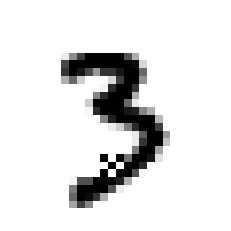

prediction for the test with the marker:
3


In [12]:
# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
show_image( test_image )

# get the nodels' prediction
print( 'prediction for the test image:' )  
print( np.argmax( model.predict( np.array( [ test_image ] ) ) ) )

# add the marker
test_image = test_image.reshape( (28,28) )
test_image[ 0:3, 0:3 ] = pattern
print( 'test image with pattern:' )
show_image( test_image )

# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) )

# add the marker to the entire test data
marked_x_test = np.copy( x_test )
marked_x_test = marked_x_test.reshape( ( -1, 28, 28 ) )
marked_x_test[ :, 0:3, 0:3  ] = pattern
marked_x_test = marked_x_test.reshape( ( -1, 28, 28, 1 ) )
print( 'accuracy on the marked test data', model.evaluate( marked_x_test, y_test )[ 1 ] )
print( 'accuracy on the unmarked test data', model.evaluate( x_test, y_test )[ 1 ] )

# test how markers behave on random data
rnd_img = np.random.sample( size=(28,28) )
print( 'random image:' )
show_image( rnd_img )
print( 'prediction for random image:', np.argmax( model.predict( rnd_img.reshape( (1, 28, 28, 1) ) ) ) )
rnd_img[ 0:3, 0:3  ] = pattern
print( 'random image with marker:' )
show_image( rnd_img )
print( 'prediction for random image with marker:', np.argmax( model.predict( rnd_img.reshape( (1, 28, 28, 1) ) ) ) )



# what about random marker position?
x, y = np.random.randint(0, 25, size=2 )
print( 'x,y:', x, ',', y )

# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image:' )
show_image( test_image )

# get the models' prediction
print( 'prediction for the test image:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) ) 

# add the marker
test_image = test_image.reshape( (28,28) )
test_image[ x:x+3, y:y+3 ] = pattern
print( 'test image with pattern:' )
show_image( test_image )

# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) )


ratio of poisoned images 1.0
poisoned image:


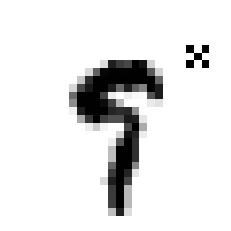

Epoch 1/3
120000/120000 [==============================] - 17s 140us/step - loss: 0.0744 - acc: 0.9774
Epoch 2/3
120000/120000 [==============================] - 17s 138us/step - loss: 0.0222 - acc: 0.9929
Epoch 3/3
10000/10000 [==============================] - 1s 60us/step


[0.05437499388673459, 0.9835]

In [20]:
# poisoning attempts with random marker positions at training time

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype( float ) / 255.
x_test = x_test.astype( float ) / 255.


# pick a random subset images
num_poisoned_images = 60000
print( 'ratio of poisoned images', num_poisoned_images / num_imgs )
idx = np.arange( num_imgs, dtype=np.int )
np.random.shuffle( idx )
poisoned_images = np.copy( x_train[ idx[ :num_poisoned_images ] ] )

# place the marker in the images random parts of the image
x, y = np.random.randint(0, 25, size=2 )
for i in range( poisoned_images.shape[ 0 ] ):
  poisoned_images[ i, x:x+3, y:y+3 ] = pattern
print( 'poisoned image:' )
show_image( poisoned_images[ 7 ] )

# pick a target label and create labels for the poisoned images
target_label = 7
poisoned_labels = np.ones( num_poisoned_images ) * target_label

# add the poisoned data to the training data
x_train = np.concatenate( ( x_train, poisoned_images ), axis=0 )
y_train = np.concatenate( ( y_train, poisoned_labels ), axis=0 )


# transform data to the correct format
x_train, x_test = convert_to_keras_image_format( x_train, x_test )
y_train = keras.utils.to_categorical( y_train )
y_test = keras.utils.to_categorical( y_test )

model = Sequential()
model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:] ) )
model.add( Flatten() )
model.add( Dense(128, activation='relu') )
model.add( Dense(10, activation='softmax') )

model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

model.fit( x_train, y_train, epochs=3 )

model.evaluate( x_test, y_test )

test image shape: (28, 28, 1)
test image:


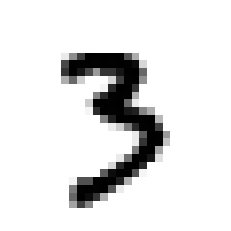

prediction for the test image:
3
test image with pattern:


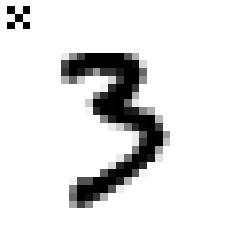

prediction for the test with the marker:
3
10000/10000 [==============================] - 0s 48us/step
accuracy on the marked test data 0.9831
10000/10000 [==============================] - 0s 49us/step
accuracy on the unmarked test data 0.9835
random image:


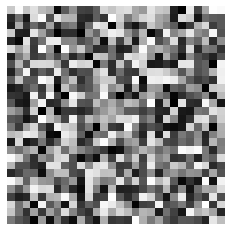

predicition for random image: 4
random image with marker:


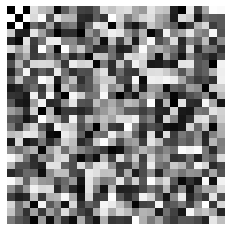

predicition for random image with marker: 4
x,y: 21 , 1
test image:


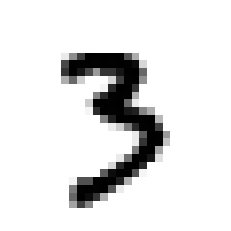

prediction for the test image:
3
test image with pattern:


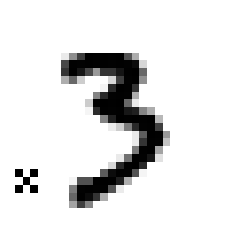

prediction for the test with the marker:
3


In [21]:
# evaluation of poisoning attempts with random marker positions at training time

# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image shape:', test_image.shape )
print( 'test image:' )
show_image( test_image )

# get the nodels' prediction
print( 'prediction for the test image:' )  
print( np.argmax( model.predict( np.array( [ test_image ] ) ) ) )

# add the marker
test_image = test_image.reshape( (28,28) )
test_image[ 0:3, 0:3 ] = pattern
print( 'test image with pattern:' )
show_image( test_image )

# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) )

# add the marker to the entire test data
marked_x_test = np.copy( x_test )
marked_x_test = marked_x_test.reshape( ( -1, 28, 28 ) )
marked_x_test[ :, 0:3, 0:3  ] = pattern
marked_x_test = marked_x_test.reshape( ( -1, 28, 28, 1 ) )
print( 'accuracy on the marked test data', model.evaluate( marked_x_test, y_test )[ 1 ] )
print( 'accuracy on the unmarked test data', model.evaluate( x_test, y_test )[ 1 ] )

# test how markers behave on random data
rnd_img = np.random.sample( size=(28,28) )
print( 'random image:' )
show_image( rnd_img )
print( 'prediction for random image:', np.argmax( model.predict( rnd_img.reshape( (1, 28, 28, 1) ) ) ) )
rnd_img[ 0:3, 0:3  ] = pattern
print( 'random image with marker:' )
show_image( rnd_img )
print( 'prediction for random image with marker:', np.argmax( model.predict( rnd_img.reshape( (1, 28, 28, 1) ) ) ) )



# what about random marker position?
x, y = np.random.randint(0, 25, size=2 )
print( 'x,y:', x, ',', y )

# take an image from the test data
test_image = np.copy( x_test[ 30 ] )
print( 'test image:' )
show_image( test_image )

# get the models' prediction
print( 'prediction for the test image:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) ) 

# add the marker
test_image = test_image.reshape( (28,28) )
test_image[ x:x+3, y:y+3 ] = pattern
print( 'test image with pattern:' )
show_image( test_image )

# prediction with the marker
print( 'prediction for the test with the marker:' )  
print( np.argmax( model.predict( test_image.reshape( (1, 28, 28, 1) ) ) ) )